In [1]:
import sys
sys.path.append('..')

import stim
from tstim import tstim
import qc_utils.tomography
import matplotlib.pyplot as plt

In [2]:
tcirc = tstim.TStimCircuit()

tcirc.append('R', [0, 1])
tcirc.append('H', 0)

tcirc.append_time_pos(0)
tcirc.append_time_depolarize([0], [0], 1.0)
tcirc.append('M', 0)
tcirc.append('DETECTOR', stim.target_rec(-1))

tcirc.to_stim().compile_detector_sampler().sample(10**4).mean()

0.5047

In [3]:
tcirc.to_stim()

stim.Circuit('''
    R 0 1
    H 0
    R 2 3
    E(0.25) X2
    ELSE_CORRELATED_ERROR(0.333333) X2 X3
    ELSE_CORRELATED_ERROR(0.5) X3
    CX 2 0
    CZ 3 0
    M 0
    DETECTOR rec[-1]
''')

In [4]:
import qc_utils.tomography.process_tomography

class StimTomography(qc_utils.tomography.process_tomography.ProcessTomography):
    def __init__(self, num_shots: int = 10**4):
        super().__init__(tstim.TStimCircuit, 1)
        self.num_shots = num_shots

    def initialize(self, state: str, **kwargs):
        self.state = tstim.TStimCircuit()
        self.state.append('R', 0)
        if state == '0':
            return
        elif state == '1':
            self.state.append('X', 0)
        elif state == '+':
            self.state.append('H', 0)
        elif state == '-':
            self.state.append('X', 0)
            self.state.append('H', 0)
        elif state == 'i':
            self.state.append('H', 0)
            self.state.append('S', 0)
        elif state == '-i':
            self.state.append('X', 0)
            self.state.append('H', 0)
            self.state.append('S', 0)
    
    def apply_process(self, **kwargs) -> None:
        # self.state.append_time_depolarize([0,1], [0,0], 1.0)
        self.state.append_time_depolarize([0], [0], 1.0)
        # self.state.append('DEPOLARIZE2', [0,1], 15/16)
        # self.state.append('E', stim.target_x(0), 0.25)
        # self.state.append('ELSE_CORRELATED_ERROR', stim.target_y(0), 1/3)
        # self.state.append('ELSE_CORRELATED_ERROR', stim.target_z(0), 0.5)
        self.state.append_time_pos(0)
    
    def measure_X(self, **kwargs):
        self.state.append('MX', 0)
        self.state.append('DETECTOR', stim.target_rec(-1))

        frac_1 = self.state.to_stim().compile_detector_sampler().sample(self.num_shots).mean()
        return [1-frac_1, frac_1]
    
    def measure_Y(self, **kwargs):
        self.state.append('MY', 0)
        self.state.append('DETECTOR', stim.target_rec(-1))

        frac_1 = self.state.to_stim().compile_detector_sampler().sample(self.num_shots).mean()
        return [1-frac_1, frac_1]
    
    def measure_Z(self, **kwargs):
        self.state.append('MZ', 0)
        self.state.append('DETECTOR', stim.target_rec(-1))

        frac_1 = self.state.to_stim().compile_detector_sampler().sample(self.num_shots).mean()
        return [1-frac_1, frac_1]

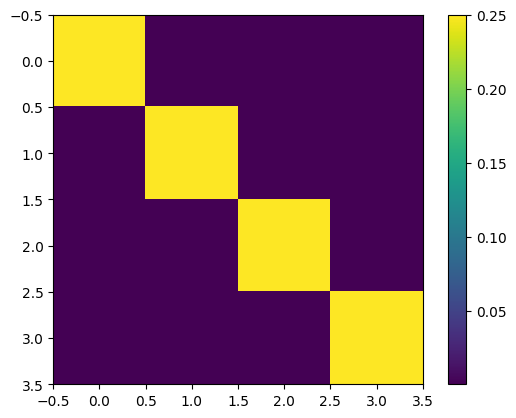

In [5]:
s = StimTomography(10**6)
chi = s.run_process_tomography()
plt.imshow(chi.__abs__())
plt.colorbar()